In [4]:
# Imports
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
import time
import pandas as pd

os.chdir("/dtu/3d-imaging-center/courses/02509/groups/members/tobias_s183478/Project/HPC3D_project/code/")
import functions as fnc

# change directory to the project directory
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

In [5]:
# load the full data, bin_data and mask for the three stones (for the the Island ny stone we also load the downsampled data)

folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01'

stone = 'island_gammel'
file_name = 'lavasten_Island_gammel_LFOV-80kV-LE5-4s-45.3micro_recon.txm'
absolute_path = os.path.join(folder_path, stone, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
bin_data = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, stone, file_name)
mask = tifffile.imread(absolute_path)


In [6]:
print(all_data[1].keys())
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(pixel_size)
img_shape = data.shape
print(img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print(pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
45.34814453125
(1017, 1024, 1004)
[46.11906299 46.4365     45.52953711]
22.051618877391707


In [7]:
# visualize the data
crop_size = int(4*pixels_per_mm)
start_x = 450#440
end_x = start_x + crop_size
start_y = 470#420
end_y = start_y + crop_size
start_z = 280#280
end_z = start_z + crop_size
slice = 100# crop_size
slice_x = start_x + slice
slice_y = start_y + slice
slice_z = start_z + slice

In [45]:
sample = data[start_z:end_z, start_x:end_x, start_y:end_y]
bin_sample = bin_data[start_z:end_z, start_x:end_x, start_y:end_y]
mask_sample = mask[start_z:end_z, start_x:end_x, start_y:end_y]

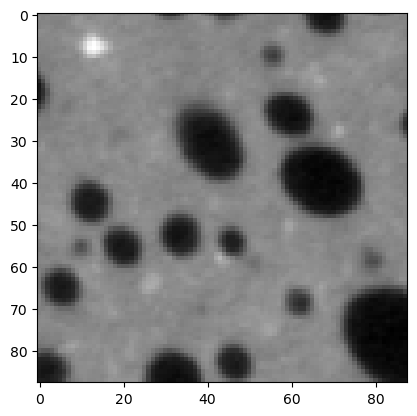

<Figure size 640x480 with 0 Axes>

In [46]:
# visualize the sample
slice = crop_size//2
fig = plt.figure()
plt.imshow(sample[slice, :, :], cmap='gray')
plt.show()
# save the sample
path = os.path.join('plots', 'sample_slice.png')
fig.savefig(path, bbox_inches='tight')



In [47]:
thickness_stone = fnc.get_thickness(bin_sample, mask_sample, pixel_size)
thickness_bubbles = fnc.get_thickness(1-bin_sample, mask_sample, pixel_size)

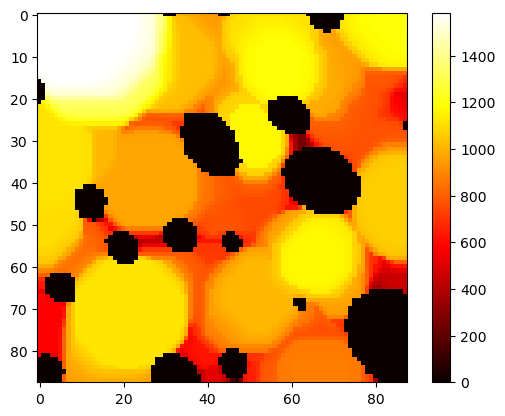

<Figure size 640x480 with 0 Axes>

In [48]:
# visualize the thickness_stone
fig = plt.figure()
plt.imshow(thickness_stone[slice, :, :], cmap='hot')
plt.colorbar()
plt.show()
# save the thickness_stone
path = os.path.join('plots', 'local_thickness_stone.png')
fig.savefig(path, bbox_inches='tight')

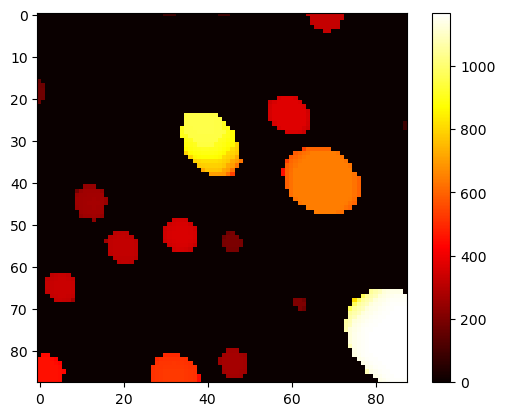

<Figure size 640x480 with 0 Axes>

In [49]:
# visualize the thickness_stone
fig = plt.figure()
plt.imshow(thickness_bubbles[slice, :, :], cmap='hot')
plt.colorbar()
plt.show()
# save the thickness_stone
path = os.path.join('plots', 'local_thickness_air.png')
fig.savefig(path, bbox_inches='tight')

## Sample Extraction

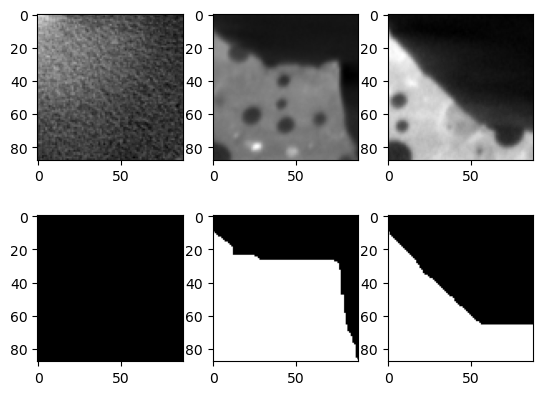

In [8]:
grid_list = fnc.extract_samples(mask=mask,
                                pixels_per_mm=pixels_per_mm,
                                mm_per_grid=4,
                                discard_threshold=0.33)

grid_dict = grid_list[10]
slice_n = 0
plt.figure()
plt.subplot(231)
plt.imshow(fnc.apply_grid(volume=all_data[0], grid_dict=grid_dict)[slice_n,:, :], cmap='gray')
plt.subplot(232)
plt.imshow(fnc.apply_grid(volume=all_data[0], grid_dict=grid_dict)[:,slice_n, :], cmap='gray')
plt.subplot(233)
plt.imshow(fnc.apply_grid(volume=all_data[0], grid_dict=grid_dict)[:,:, slice_n], cmap='gray')
plt.subplot(234)
plt.imshow(fnc.apply_grid(volume=mask, grid_dict=grid_dict)[slice_n, : ,:], cmap='gray', vmin=0, vmax=1)
plt.subplot(235)
plt.imshow(fnc.apply_grid(volume=mask, grid_dict=grid_dict)[:, slice_n, :], cmap='gray', vmin=0, vmax=1)
plt.subplot(236)
plt.imshow(fnc.apply_grid(volume=mask, grid_dict=grid_dict)[:,:, slice_n], cmap='gray', vmin=0, vmax=1)
plt.show()

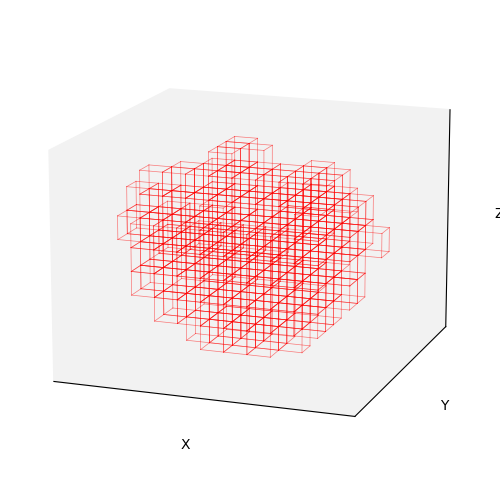

In [10]:
save_path = "/dtu/3d-imaging-center/courses/02509/groups/group01/other/"
#Note: Try and get the exact camera data for use with tomviz
fnc.plot_samples(mask, grid_list, view=(15, 110), linewidth=0.5, alpha=0.5, save_path=save_path)